# Preparation

In [117]:
import iminuit
%load_ext ipycache
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy import optimize
import seaborn as sns
from theano.compile.ops import as_op
import theano.tensor as tt

sns.set_style('darkgrid')
sns.set_context('notebook')

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [118]:
results = pd.DataFrame()

# Load C14 models

In [119]:
import c14_models

# Read patient data

In [120]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [121]:
exp_data = c14_patient_data.query('type == "hepatocyte"')
exp_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# SSE & log-likelihood

In [6]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [7]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [8]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [9]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    if Dbirth >= Dcoll:
        return np.nan
    else:
        lam = np.exp(loglam)
        return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [10]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

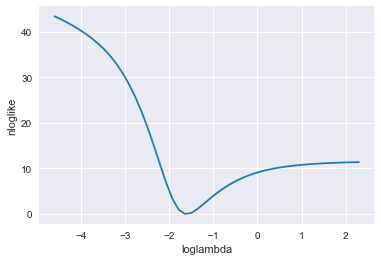

In [11]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

## Result

In [13]:
lam1 = sp.exp(res[0])
print('lamda', lam1)

sig1 = Sigma([np.log(lam1)], I1, exp_data)
print('sigma', sig1)

results.loc['I1', 'loglike'] = -res[1]
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.193069772888
sigma 0.0168354005996


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.53265


# IL

In [14]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    if Dbirth >= Dcoll:
        return np.nan
    else:
        lam = np.exp(loglam)
        return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [13]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.   0.5]
-49.9042319103


Quick dirty hack to fit fast:

In [15]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.31), np.log(0.32)), (0.47, 0.48)],
                  args = (IL, exp_data),
                  Ns = 3,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.17118298  0.48      ]
-50.7318488144


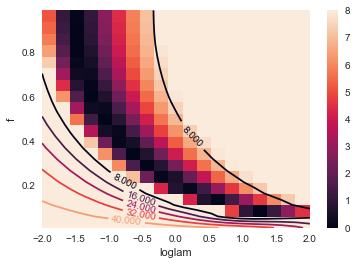

In [19]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [16]:
lamL = sp.exp(res[0][0])
print('lamda', lamL)

fL = res[0][1]
print('f', fL)

sigL = Sigma([np.log(lamL), fL], IL, exp_data)
print('sigma', sigL)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.31
f 0.48
sigma 0.0167553806539


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IL,50.731849,3.0,19.0,-93.863698


# Results

In [18]:
results.sort_values('cAIC')

,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IL,50.731849,3.0,19.0,-93.863698


# Compare

In [64]:
%%cache C.pkl C_I1 C_IL
n = 50
bb = np.linspace(1900, 1950, n)
dd = np.linspace(1900, 2018, n)

BB, DD = np.meshgrid(bb, dd)

C_I1 = I1(BB, DD, np.log(lam1))
C_IL = IL(BB, DD, np.log(lamL), fL)

[Saved variables 'C_I1, C_IL' to file '/home/fabrost/work/C14_liver/C.pkl'.]


In [72]:
dd

array([ 1900.        ,  1902.40816327,  1904.81632653,  1907.2244898 ,
        1909.63265306,  1912.04081633,  1914.44897959,  1916.85714286,
        1919.26530612,  1921.67346939,  1924.08163265,  1926.48979592,
        1928.89795918,  1931.30612245,  1933.71428571,  1936.12244898,
        1938.53061224,  1940.93877551,  1943.34693878,  1945.75510204,
        1948.16326531,  1950.57142857,  1952.97959184,  1955.3877551 ,
        1957.79591837,  1960.20408163,  1962.6122449 ,  1965.02040816,
        1967.42857143,  1969.83673469,  1972.24489796,  1974.65306122,
        1977.06122449,  1979.46938776,  1981.87755102,  1984.28571429,
        1986.69387755,  1989.10204082,  1991.51020408,  1993.91836735,
        1996.32653061,  1998.73469388,  2001.14285714,  2003.55102041,
        2005.95918367,  2008.36734694,  2010.7755102 ,  2013.18367347,
        2015.59183673,  2018.        ])

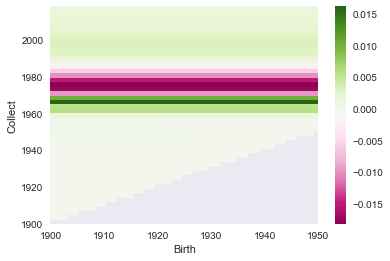

In [65]:
plt.pcolormesh(BB, DD, C_I1-C_IL, cmap='PiYG')
plt.colorbar()

plt.xlabel('Birth')
plt.ylabel('Collect')

plt.show()

Maximum difference

In [89]:
absdiff = np.abs(C_I1-C_IL)
print(np.nanmax(absdiff))
print(BB.flat[np.nanargmax(absdiff)])
print(DD.flat[np.nanargmax(absdiff)])

0.0181819551959
1950.0
1974.65306122


# Artifical data

In [179]:
np.random.seed(42)

n = 30
bb = np.random.uniform(1900, 1970, n)
dd = 1974

Cart = IL(bb, dd, np.log(lamL), fL) + np.random.normal(0, sigL, n)

In [180]:
exp_data = c14_patient_data.query('type == "hepatocyte"')
art_data = pd.DataFrame({'Dbirth': bb, 'Dcoll': dd, 'd14C': Cart})
exp_data = pd.concat([exp_data, art_data], ignore_index=True)

# Scenario I1 - artifical data

In [181]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    if Dbirth >= Dcoll:
        return np.nan
    else:
        lam = np.exp(loglam)
        return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [182]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

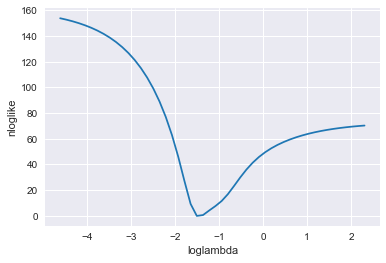

In [183]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

## Result

In [184]:
lam1 = sp.exp(res[0])
print('lamda', lam1)

sig1 = Sigma([np.log(lam1)], I1, exp_data)
print('sigma', sig1)

results.loc['I1', 'loglike'] = -res[1]
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.222299648253
sigma 0.0156331984471


,loglike,k,n,cAIC
I1,134.231579,2.0,49.0,-264.202289
IL,190.329264,3.0,69.0,-374.289298


# IL

In [185]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    if Dbirth >= Dcoll:
        return np.nan
    else:
        lam = np.exp(loglam)
        return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [189]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-0.22222222  0.22777778]
-135.765975851


Quick dirty hack to fit fast:

In [186]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.31), np.log(0.32)), (0.47, 0.48)],
                  args = (IL, exp_data),
                  Ns = 3,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.17118298  0.47      ]
-135.585315531


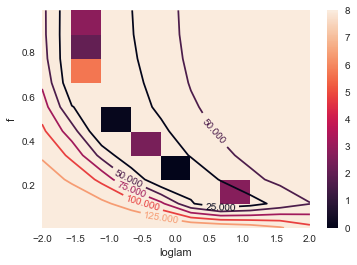

In [190]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [191]:
lamL = sp.exp(res[0][0])
print('lamda', lamL)

fL = res[0][1]
print('f', fL)

sigL = Sigma([np.log(lamL), fL], IL, exp_data)
print('sigma', sigL)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.800737402917
f 0.227777777778
sigma 0.0151512425446


,loglike,k,n,cAIC
I1,134.231579,2.0,49.0,-264.202289
IL,135.765976,3.0,49.0,-264.998618


# Results

In [192]:
results.sort_values('cAIC')

,loglike,k,n,cAIC
IL,135.765976,3.0,49.0,-264.998618
I1,134.231579,2.0,49.0,-264.202289
